# PVH-TH Analysis Code

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
import os

### Define Main Functions

In [76]:
def load_data(filename, prefix):
    '''
    Returns a cleaned pandas dataframe from the specified
    file pathway.
    '''
    data = pd.read_csv(prefix + filename)
    data = data.fillna(0)
    # data = data[data['Event'] == 'Pellet']
    return data


def process_data(data):
    '''
    Returns a dataframe of two columns consisting of number of
    pellets eaten and cumulative time. This function assumes that a
    pellet was taken at the start of the FED-3 recording.
    '''
    intervals = data['InterPelletInterval']
    cumulative = []
    for i in range(len(intervals)):
        if i == 0:
            cumulative.append(0)
        else:
            cumulative.append(cumulative[i-1] + intervals[i])
    data['CumulativePelletInterval'] = cumulative

    # Add point at end that has max time
    new_data = data[['Pellet_Count', 'CumulativePelletInterval']]
    new_data = new_data[new_data['Pellet_Count'] > 0]
    new_data = new_data[new_data['CumulativePelletInterval'] <= 10600]

    # Remove the one pellet taken to mark the start
    new_data['Pellet_Count'] = new_data.loc[:, 'Pellet_Count'] - 1 

    # Add point at start and end
    new_data.loc[-1] = [0, 0]
    new_data.index = new_data.index + 1
    new_data.sort_index(inplace=True)
    new_data.loc[-1] = [new_data.iloc[-1, 0], 10600] 
    new_data = new_data.reset_index(drop=True)
    # new_data = new_data.drop(columns=['index'])

    # Convert to minutes
    new_data['CumulativePelletInterval'] = new_data['CumulativePelletInterval'] / 60
    # print('Total pellets: ' + str(new_data['Pellet_Count'].max()))
    return new_data


def get_total(data):
    '''
    Returns the total number of pellets eaten by each mouse
    '''
    return data['Pellet_Count'].max()


def plot_data(data, mouse_num, date):
    '''
    Plots and saves a regression plot of the provided dataframe and
    mouse number
    '''
    fig, ax = plt.subplots(1, 1)
    sns.set()
    sns.lineplot(data=data, x='CumulativePelletInterval', y='Pellet_Count',
                 ax=ax, drawstyle='steps-post')
    ax.set_title('Food Intake over Time | Mouse ' + str(mouse_num))
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel('Total Pellets Eaten')
    ax.set_xlim(-3, 180)
    ax.axvline(60, color='red', linewidth=1, linestyle='--')
    ax.axvline(120, color='red', linewidth=1, linestyle='--')
    ax.axvspan(60, 120, color='red', alpha=0.1, lw=0)
    plt.savefig('Plots/' + date + ' Intake Data Mouse #' + str(mouse_num)[1] + '.png', 
                bbox_inches='tight')
    # plt.show()
    plt.close()


def plot_data_grid(data, mouse_num, date, ax):
    '''
    Plots and saves a regression plot of the provided dataframe and
    mouse number in a provided subplot.
    '''
    sns.set()
    sns.lineplot(data=data, x='CumulativePelletInterval', y='Pellet_Count',
                 ax=ax, drawstyle='steps-post')
    ax.set_title('Food Intake over Time | Mouse ' + mouse_num[1] + ' (' + date + ')')
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel('Total Pellets Eaten')
    # ax.set_ylim(-3, 40)
    ax.set_xlim(-3, 180)
    ax.axvspan(60, 120, color='red', alpha=0.1, lw=0)


def format_plot(ax, title):
    '''
    Adds a title, x and y axis labels, and shades area where opto fiber
    was on.
    '''
    ax.set_title(title)
    ax.set_xlabel('Time (mins)')
    ax.set_ylabel('Total Pellets Eaten')
    # ax.axvline(60, color='red', linewidth=1, linestyle='--')
    # ax.axvline(120, color='red', linewidth=1, linestyle='--')
    ax.axvspan(60, 120, color='red', alpha=0.1, lw=0)


def linear(x, m, b):
    return m*x + b


def exponential(x, a, b, c):
    return a*(x**c) + b


def plot_curve_fit_intervals(data):
    '''
    Plots line of best fit with slope for each interval of time
    '''
    masks = [
        (data['CumulativePelletInterval'] <= 60),
        (data['CumulativePelletInterval'] >= 60) & (data['CumulativePelletInterval'] <= 120),
        (data['CumulativePelletInterval'] >= 120),
    ]
    xranges = [
        np.linspace(0, 60, 100),
        np.linspace(60, 120, 100),
        np.linspace(120, 180, 100)
    ]
    colors = [
        'C2',
        'C5',
        'C4'
    ]
    for mask, xrange, color in zip(masks, xranges, colors):
        xdata = data[mask]['CumulativePelletInterval'].to_numpy()
        ydata = data[mask]['Pellet_Count'].astype(float).to_numpy()
        params, pcov = curve_fit(linear, xdata, ydata)
        ax.plot(xrange, linear(xrange, *params), '--', color=color,
                label='Linear Fit (slope=' + str(round(params[0], 5)) + ')')
    ax.set_ylim(-3, 50)
    ax.legend()


### Load Filenames and Info

In [77]:
filenames = os.listdir('Cleaned Up Data')
for filename in filenames.copy():
    if 'BAD' in filename.upper():
        filenames.remove(filename)
    elif '08292022' in filename:
        filenames.remove(filename)

filenames_dict = {}
for i in range(len(filenames)):
    filenames_dict[filenames[i]] = filenames[i].split('_')[0:5]

filenames_dict

{'F1_M1_L8_S2_08312022_Clean.CSV': ['F1', 'M1', 'L8', 'S2', '08312022'],
 'F2_M2_L7_S2_08312022_Clean.CSV': ['F2', 'M2', 'L7', 'S2', '08312022'],
 'F4_M4_L6_S2_08312022_Clean.CSV': ['F4', 'M4', 'L6', 'S2', '08312022'],
 'F5_M5_L5_S2_08312022_Clean.CSV': ['F5', 'M5', 'L5', 'S2', '08312022'],
 'F7_M7_L2_S2_08312022_Clean.CSV': ['F7', 'M7', 'L2', 'S2', '08312022'],
 'F8_M6_L4_S2_08312022_Clean.CSV': ['F8', 'M6', 'L4', 'S2', '08312022']}

### Plot and Save Individual Food Intake Plots

In [78]:
# Initialize dataframe to be filled for plotting
master_data = pd.DataFrame(columns=['Mouse #', 'Cohort', 'Pellet_Count', 'CumulativePelletInterval'], dtype=float)

# Process and plot all data
for filename, info in zip(filenames_dict.keys(), filenames_dict.values()):
    data = load_data(filename, 'Cleaned Up Data/')
    data = process_data(data)
    plot_data(data, info[1], info[4])
    data[['Mouse #', 'Cohort']] = [info[1], info[3]]
    master_data = master_data.append(data)

print('INDIVIDUAL PLOTS HAVE BEEN SAVED TO FOLDER')
# mouse_cage_weight = master_df[['Cage #', 'Mouse #', 'Initial Weight (g)']]
# master_data = mouse_cage_weight.merge(master_data, left_on='Mouse #', right_on='Mouse #', how='inner')
master_data

INDIVIDUAL PLOTS HAVE BEEN SAVED TO FOLDER


,Mouse #,Cohort,Pellet_Count,CumulativePelletInterval
0,M1,S2,0.0,0.000000
1,M1,S2,0.0,0.000000
2,M1,S2,1.0,0.700000
3,M1,S2,2.0,1.816667
4,M1,S2,3.0,2.700000
...,...,...,...,...
101,M6,S2,37.0,162.450000
102,M6,S2,38.0,163.733333
103,M6,S2,39.0,164.650000
104,M6,S2,39.0,164.650000


### Plot all individual graphs in a single grid

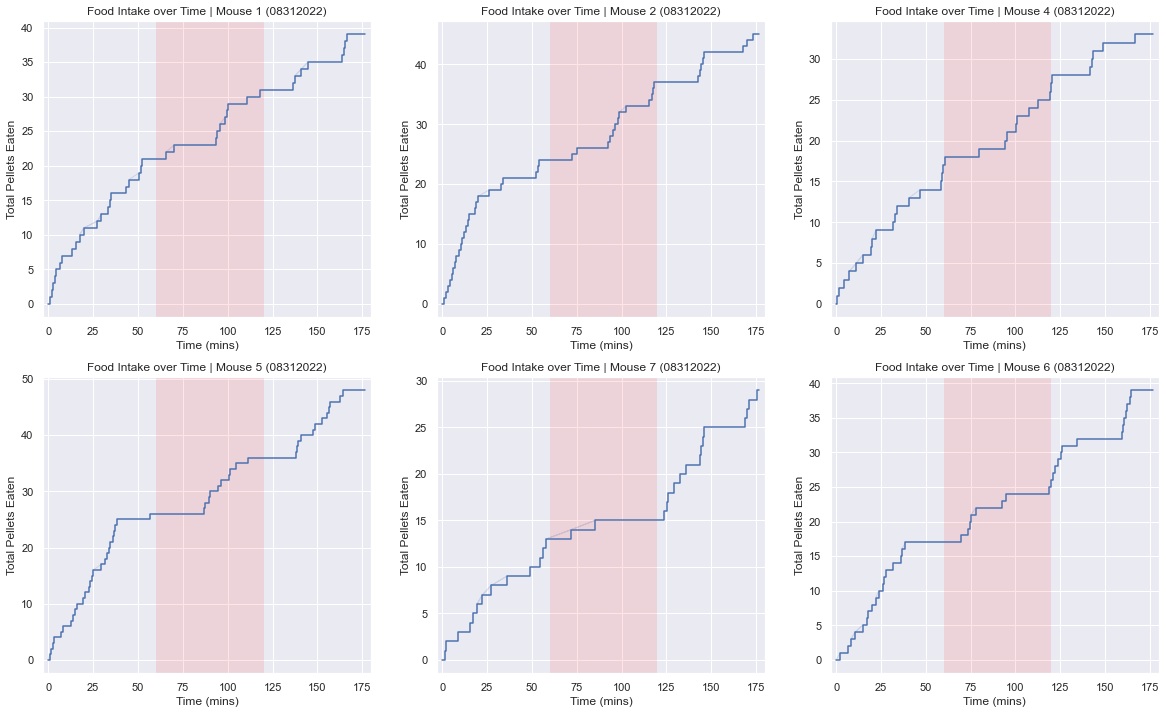

In [79]:
# Determine grid size, create grid, and convert axes to iterable list
num_rows = math.ceil((len(filenames)) / 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows*6))
axes_list = axes.ravel()

# Plot each graph sequentially on the grid
for filename, info, ax in zip(filenames_dict.keys(), filenames_dict.values(), axes_list):
    data = load_data(filename, 'Cleaned Up Data/')
    data = process_data(data)
    plot_data_grid(data, info[1], info[4], ax)
    data[['Mouse #', 'Cohort']] = [info[1], info[3]]
    master_data = master_data.append(data)

plt.savefig('Plots/All Individual Mice Grid.png')
plt.show()

### Overlay all food intake curves by mouse and cohort

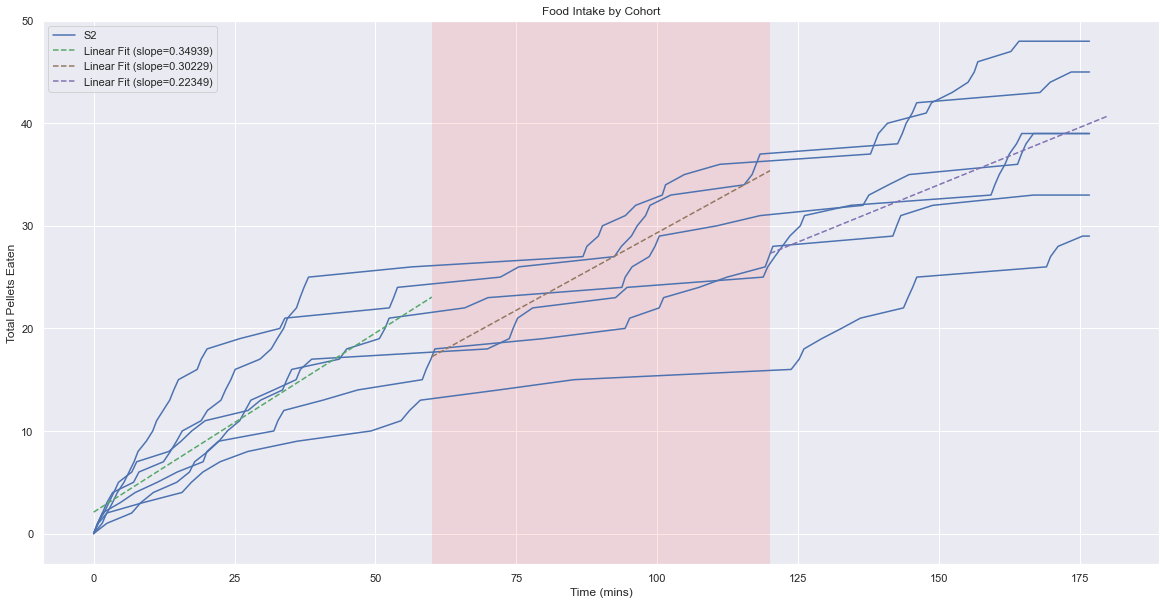

ValueError: `ydata` must not be empty!

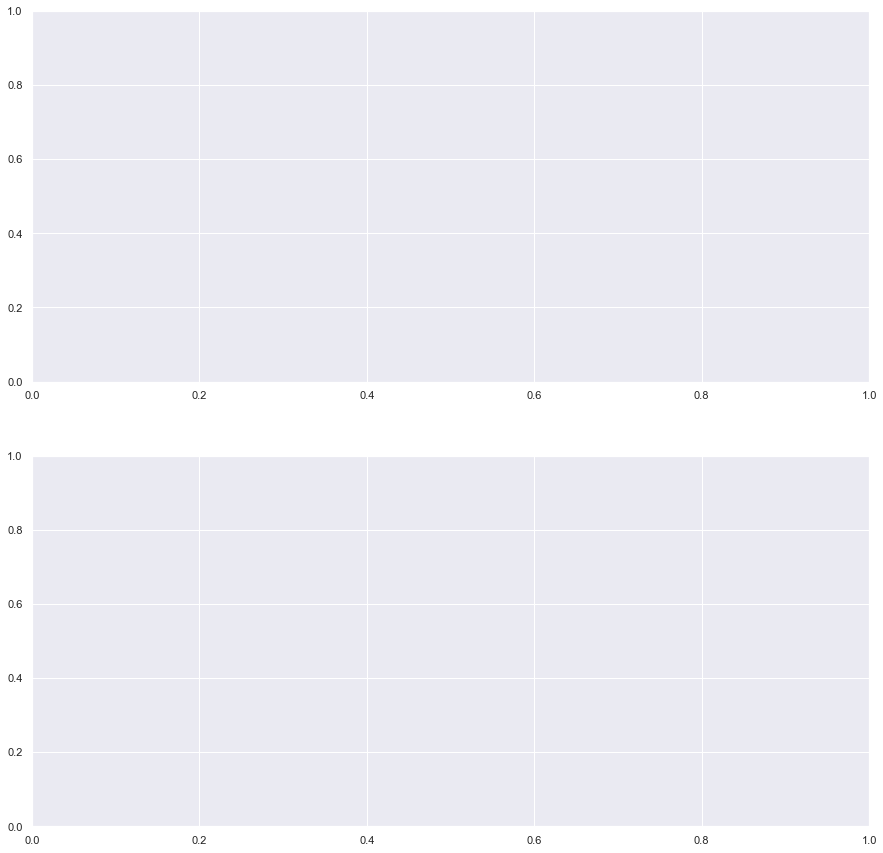

In [80]:
# Plot all mice food intake curves on the same graph
master_data = master_data.reset_index(drop=True)
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=master_data, x='CumulativePelletInterval', y='Pellet_Count', 
             ax=ax, hue='Cohort', units='Mouse #', estimator=None, palette='deep')
plot_curve_fit_intervals(master_data)
format_plot(ax, 'Food Intake by Cohort')
plt.savefig('Plots/All Mice.png')
plt.show()

# Plot all mice food intake curves separated by cohort groups 
cohort1_data, cohort2_data = master_data[master_data['Cohort'] == 'S1'],\
                             master_data[master_data['Cohort'] == 'S2']
all_cohort_data = {'Cohort 1':cohort1_data, 'Cohort 2':cohort2_data}
fig, axes = plt.subplots(2, 1, figsize=(15, 15))
for cohort, ax, color in zip(all_cohort_data.items(), axes.ravel(), ['C0', 'C1']):
    sns.lineplot(data=cohort[1], x='CumulativePelletInterval', y='Pellet_Count', ax=ax,
                 units='Mouse #', estimator=None, color=color, drawstyle='steps-post', linewidth=2)
    plot_curve_fit_intervals(cohort[1])
    format_plot(ax, cohort[0])
plt.savefig('Plots/All Mice Separated by Cohort.png')
plt.show()